In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import (Stepwise, sklearn_selected, sklearn_selection_path)
#!pip install l0bnb
#from l0bnb import fit_path -> requires numpa which requires too old numpy

In [6]:
Hitters = load_data('Hitters')
np.isnan(Hitters['Salary']).sum()

np.int64(59)

In [8]:
Hitters = Hitters.dropna()
Hitters.shape

(263, 20)

In [9]:
# Define C_p as a custom function for sklearn

def nCp(sigma2, estimator, X, Y):
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y-Yhat)**2)
    return -(RSS + 2*p*sigma2)/n

In [10]:
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
sigma2 = OLS(Y,X).fit().scale

In [11]:
neg_Cp = partial(nCp,sigma2)

In [12]:
strategy = Stepwise.first_peak(design,direction='forward',max_terms=len(design.terms))

In [15]:
hitters_MSE = sklearn_selected(OLS,strategy)
hitters_MSE.fit(Hitters,Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

In [16]:
hitters_Cp = sklearn_selected(OLS,strategy,scoring=neg_Cp)
hitters_Cp.fit(Hitters,Y)
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

In [17]:
strategy = Stepwise.fixed_steps(design,len(design.terms),direction='forward')
full_path = sklearn_selection_path(OLS,strategy)

In [18]:
full_path.fit(Hitters, Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

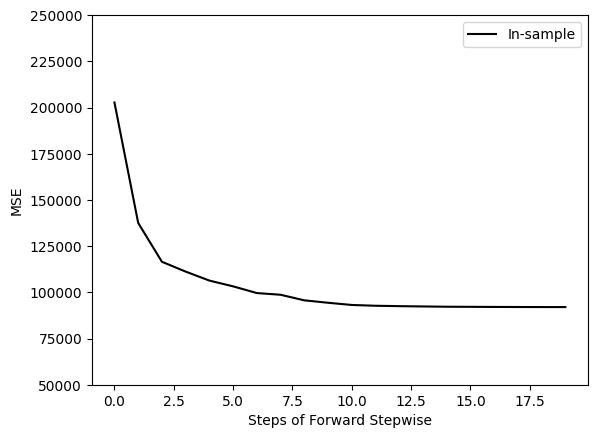

In [20]:
plt.figure()
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
plt.plot(np.arange(n_steps),insample_mse,'k',label='In-sample')
plt.ylabel('MSE')
plt.xlabel('Steps of Forward Stepwise')
plt.legend()
plt.ylim([50000,250000])
plt.show()

In [25]:
K = 5
kfold = skm.KFold(K,random_state=0,shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path,Hitters,Y,cv=kfold)
Yhat_cv.shape

(263, 20)

In [26]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx,None])**2
    cv_mse.append(errors.mean(0))
cv_mse = np.array(cv_mse).T
cv_mse.shape

(20, 5)

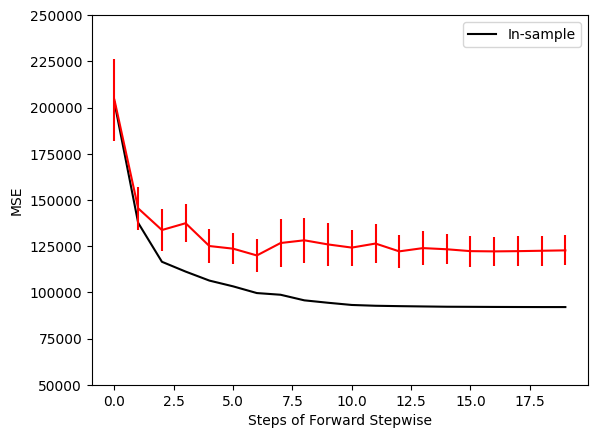

In [29]:
plt.figure()
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
plt.plot(np.arange(n_steps),insample_mse,'k',label='In-sample')
plt.ylabel('MSE')
plt.xlabel('Steps of Forward Stepwise')
plt.legend()
plt.ylim([50000,250000])
plt.errorbar(np.arange(n_steps),cv_mse.mean(1),cv_mse.std(1)/np.sqrt(K), 
             label='Cross-validated',c='r')
plt.show()

In [30]:
validation = skm.ShuffleSplit(n_splits=1,test_size=0.2,random_state=0)
for train_idx, test_idx in validation.split(Y):
    full_path.fit(Hitters.iloc[train_idx], Y[train_idx])
    Yhat_val = full_path.predict(Hitters.iloc[test_idx])
    errors = (Yhat_val - Y[test_idx,None])**2
    validation_mse = errors.mean(0)

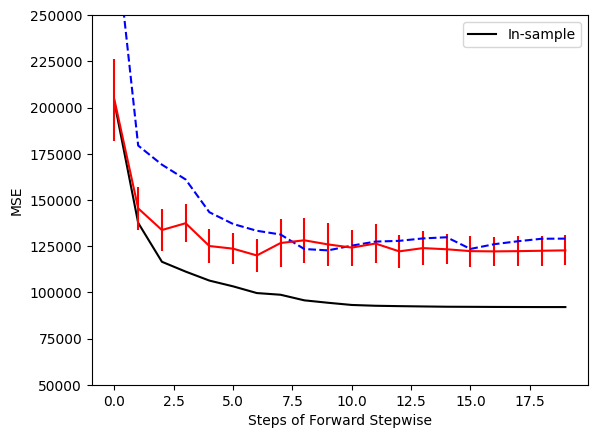

In [32]:
plt.figure()
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
plt.plot(np.arange(n_steps),insample_mse,'k',label='In-sample')
plt.ylabel('MSE')
plt.xlabel('Steps of Forward Stepwise')
plt.legend()
plt.ylim([50000,250000])
plt.errorbar(np.arange(n_steps),cv_mse.mean(1),cv_mse.std(1)/np.sqrt(K), 
             label='Cross-validated',c='r')
plt.plot(np.arange(n_steps),validation_mse,'b--',label='Validation')
plt.show()

In [ ]:
# have to stop here, no access to l0bnb in current environment

In [34]:
#PCR and PLS
pca = PCA(n_components=2)
linreg = skl.LinearRegression()
pipe = Pipeline([('pca',pca),('linreg',linreg)])
pipe.fit(X,Y)
pipe.named_steps['linreg'].coef_

array([0.09846131, 0.4758765 ])

In [36]:
pca = PCA(n_components=2)
linreg = skl.LinearRegression()
scaler = StandardScaler(with_mean=True,with_std=True)
pipe = Pipeline([('scaler',scaler),('pca',pca),('linreg',linreg)])
pipe.fit(X,Y)
pipe.named_steps['linreg'].coef_

array([106.36859204,  21.60350456])

In [43]:
param_grid = {'pca__n_components':range(1,20)}
grid = skm.GridSearchCV(pipe,param_grid,cv=kfold,scoring='neg_mean_squared_error')
grid.fit(X,Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

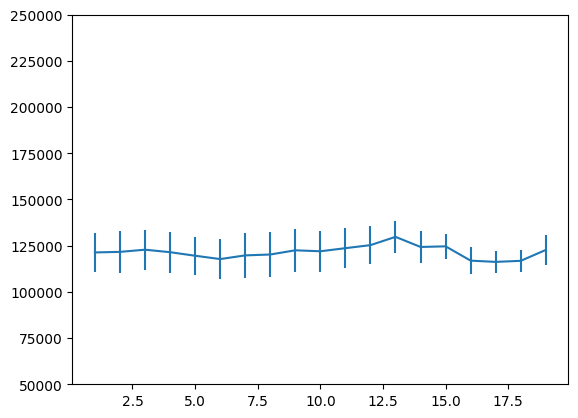

In [47]:
plt.figure()
n_comp = param_grid['pca__n_components']
plt.errorbar(n_comp,-grid.cv_results_['mean_test_score'], grid.cv_results_['std_test_score'] / np.sqrt(K))
plt.ylim([50000,250000])
plt.show()

In [50]:
pls = PLSRegression(n_components=2,scale=True)
pls.fit(X,Y)

PLSRegression()

In [55]:
param_grid = {'n_components':range(1,20)}
grid = skm.GridSearchCV(pls,param_grid,cv=kfold,scoring='neg_mean_squared_error')
grid.fit(X,Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

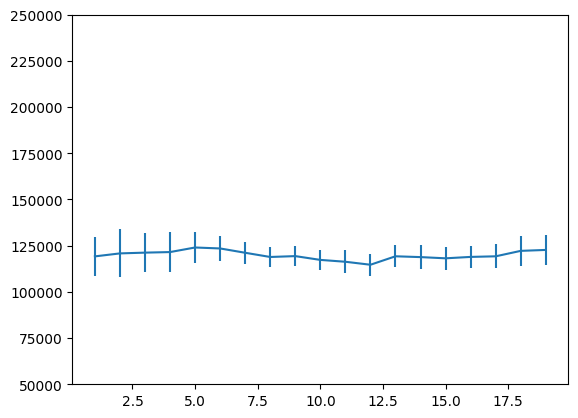

In [56]:
plt.figure()
n_comp = param_grid['n_components']
plt.errorbar(n_comp,-grid.cv_results_['mean_test_score'], grid.cv_results_['std_test_score'] / np.sqrt(K))
plt.ylim([50000,250000])
plt.show()